In [35]:
import sys
sys.path.insert(0, '../../../pyLDLE2/')
sys.path.insert(0, '../src/')

import numpy as np
import networkx as nx
import ConnectionNetworkX as cnx

from matplotlib import pyplot as plt
from matplotlib import cm

from pyLDLE2 import datasets, visualize_

In [62]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/nbks/../src/ConnectionNetworkX.py'>

In [74]:
def draw3d(G, pos, node_color, node_size, edge_color, edge_width=1, figsize=(8,4)):
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        ax.plot(*vizedge.T, color=edge_color[i], linewidth=edge_width)

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load data

In [5]:
X, labelsMat, _ = datasets.Datasets().sphere(n=2000)

X.shape =  (2000, 3)


<IPython.core.display.Javascript object>


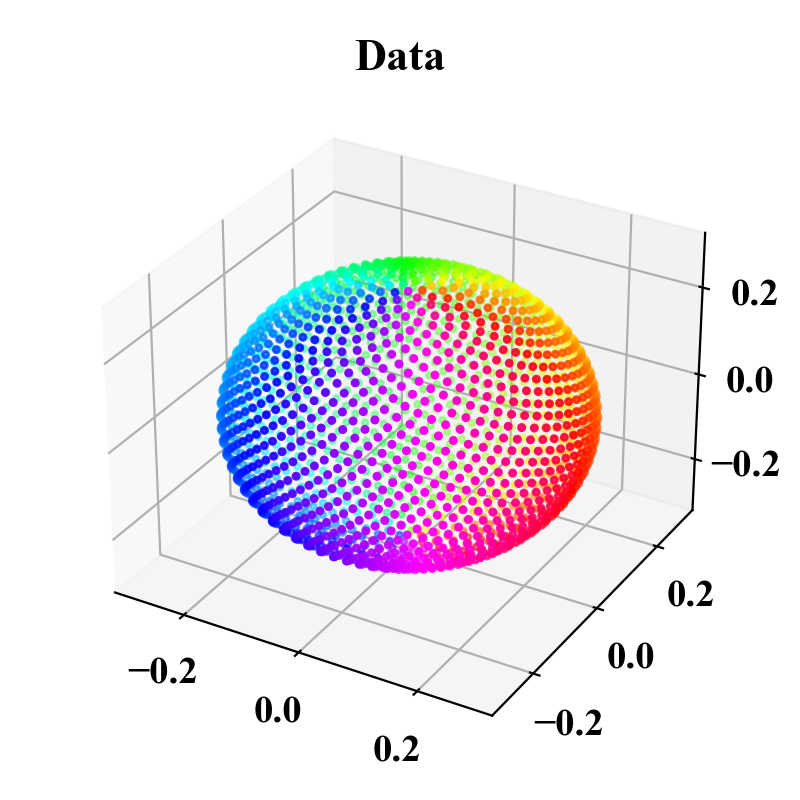

In [6]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

# Set source and destination nodes

In [7]:
source = 0
dest1 = 1597
dest2 = 1561

<IPython.core.display.Javascript object>


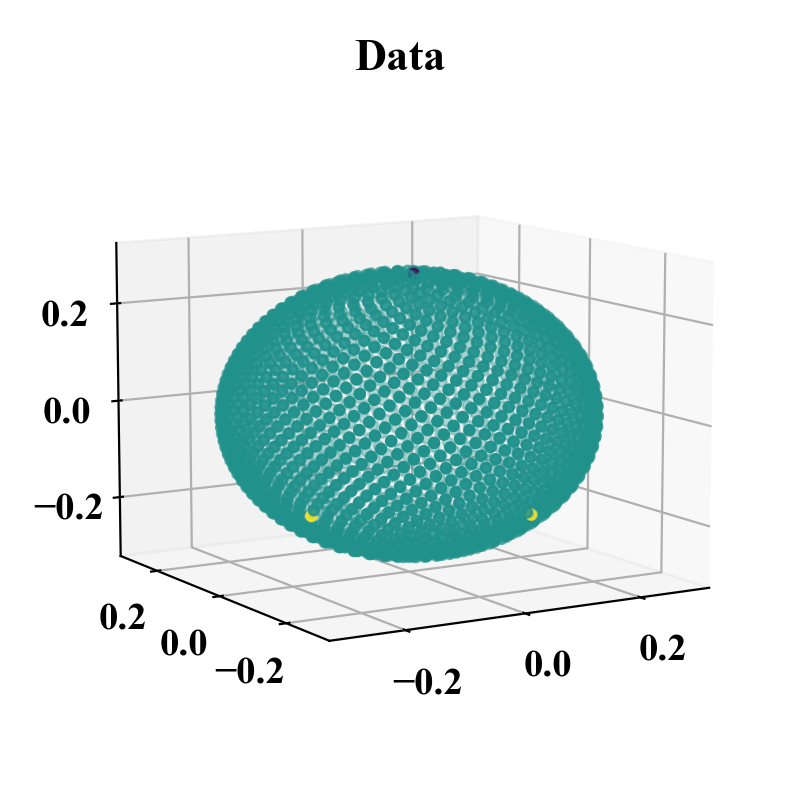

In [16]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[source] = -1
labels[dest1] = 1
labels[dest2] = 1
vis.data(X, labels, cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)

#  Build connection graph

In [30]:
eps_pca = 0.05
eps = eps_pca
d = 2
CG = cnx.cnxFromData(X, eps_pca, eps, d=d, tol=1, triv_sigma=True)

Total edges before removal: 15550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3701.40it/s]


Proportion of edges which were removed due to remoteness:  0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:25<00:00, 23.35it/s]


# Set B, w, mu, nu, c

In [31]:
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
w = np.array(list(nx.get_edge_attributes(CG, 'weight').values()))

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest1 * d, :] = 1
nu[dest2 * d+1, :] = 1

c = (mu - nu)

# Plot c

<IPython.core.display.Javascript object>


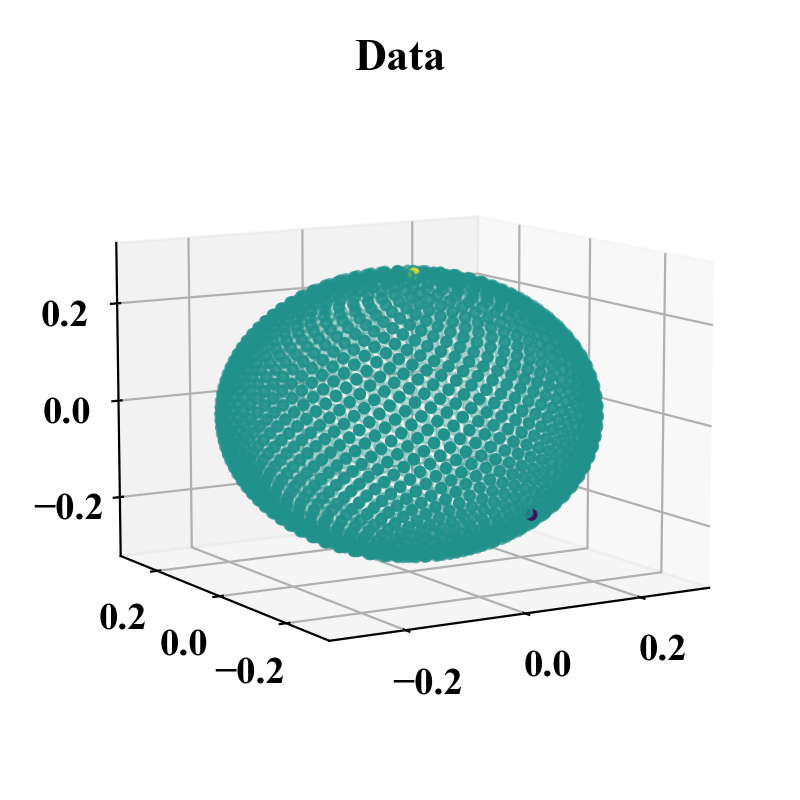

<IPython.core.display.Javascript object>


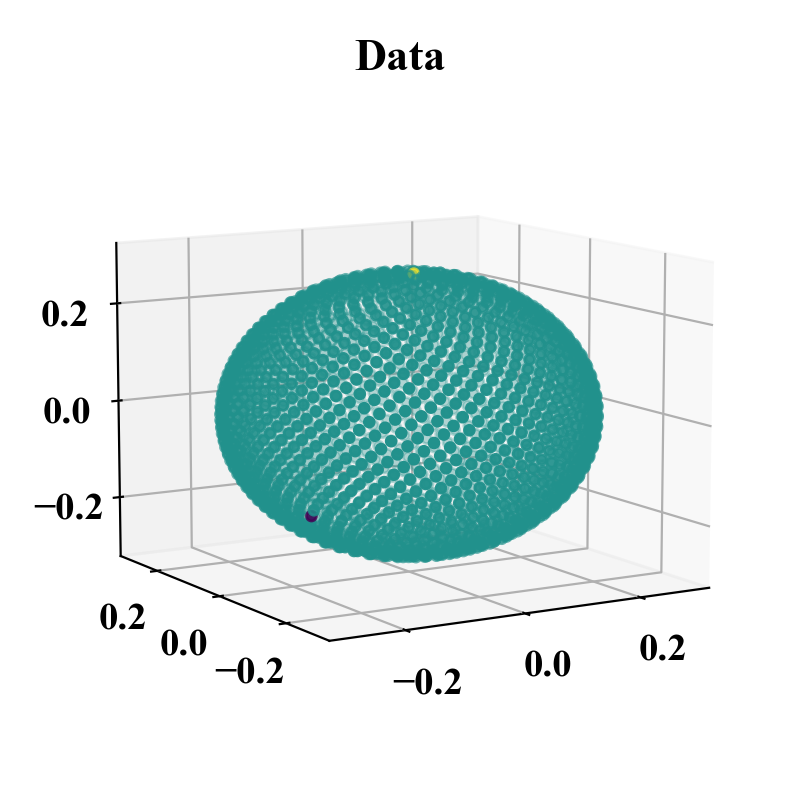

In [32]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, c.reshape((n,d))[:,0], cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)
vis.data(X, c.reshape((n,d))[:,1], cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)

# Check feasibility of primal i.e. $B^TJ = c$

In [34]:
temp_J, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c, rcond=None)
print('Error is:', np.linalg.norm(c.flatten() - B.T.dot(temp_J).flatten())) # if this is small then feasible

Error is: 2.1134997435377698e-14


# Solve Beckmann dual using gradient descent

In [44]:
learning_rate = 0.1
alpha = np.max(w)
n_epochs = 5000

phi, phi0 = cnx.optimize_(B, w, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

Initial loss: (tensor(-2.5071), tensor(0.1147))
epoch: 0, loss: -2.237320, loss0: -2.507060, loss1: 0.114747
epoch: 10, loss: -4.500629, loss0: -4.687981, loss1: 0.079699
epoch: 20, loss: -6.022639, loss0: -6.186167, loss1: 0.069564
epoch: 30, loss: -7.208218, loss0: -7.478586, loss1: 0.115014
epoch: 40, loss: -8.160888, loss0: -8.530402, loss1: 0.157191
epoch: 50, loss: -8.942483, loss0: -9.316168, loss1: 0.158965
epoch: 60, loss: -9.629030, loss0: -10.044921, loss1: 0.176919
epoch: 70, loss: -10.239536, loss0: -10.584964, loss1: 0.146944
epoch: 80, loss: -10.826658, loss0: -11.185784, loss1: 0.152772
epoch: 90, loss: -11.270449, loss0: -11.738472, loss1: 0.199096
epoch: 100, loss: -11.561729, loss0: -12.063175, loss1: 0.213314
epoch: 110, loss: -11.735664, loss0: -12.283433, loss1: 0.233020
epoch: 120, loss: -11.849265, loss0: -12.429087, loss1: 0.246655
epoch: 130, loss: -11.918756, loss0: -12.519625, loss1: 0.255608
epoch: 140, loss: -11.967107, loss0: -12.596235, loss1: 0.267630
e

epoch: 1260, loss: -12.067211, loss0: -12.770536, loss1: 0.299193
epoch: 1270, loss: -12.064378, loss0: -12.773044, loss1: 0.301465
epoch: 1280, loss: -12.067487, loss0: -12.779533, loss1: 0.302903
epoch: 1290, loss: -12.067451, loss0: -12.780861, loss1: 0.303483
epoch: 1300, loss: -12.062531, loss0: -12.775228, loss1: 0.303180
epoch: 1310, loss: -12.057446, loss0: -12.770442, loss1: 0.303307
epoch: 1320, loss: -12.063994, loss0: -12.769287, loss1: 0.300030
epoch: 1330, loss: -12.058112, loss0: -12.771096, loss1: 0.303302
epoch: 1340, loss: -12.067587, loss0: -12.774976, loss1: 0.300922
epoch: 1350, loss: -12.068860, loss0: -12.775720, loss1: 0.300697
epoch: 1360, loss: -12.064113, loss0: -12.782121, loss1: 0.305439
epoch: 1370, loss: -12.067839, loss0: -12.773039, loss1: 0.299991
epoch: 1380, loss: -12.066312, loss0: -12.777576, loss1: 0.302571
epoch: 1390, loss: -12.068042, loss0: -12.776018, loss1: 0.301172
epoch: 1400, loss: -12.066964, loss0: -12.771385, loss1: 0.299659
epoch: 141

epoch: 2520, loss: -12.064595, loss0: -12.780436, loss1: 0.304517
epoch: 2530, loss: -12.070565, loss0: -12.784670, loss1: 0.303779
epoch: 2540, loss: -12.068831, loss0: -12.770895, loss1: 0.298657
epoch: 2550, loss: -12.070268, loss0: -12.783264, loss1: 0.303307
epoch: 2560, loss: -12.074270, loss0: -12.784321, loss1: 0.302054
epoch: 2570, loss: -12.075150, loss0: -12.788031, loss1: 0.303258
epoch: 2580, loss: -12.076700, loss0: -12.787790, loss1: 0.302496
epoch: 2590, loss: -12.075616, loss0: -12.785574, loss1: 0.302015
epoch: 2600, loss: -12.082363, loss0: -12.788127, loss1: 0.300231
epoch: 2610, loss: -12.084393, loss0: -12.787203, loss1: 0.298974
epoch: 2620, loss: -12.082382, loss0: -12.791191, loss1: 0.301526
epoch: 2630, loss: -12.082258, loss0: -12.791821, loss1: 0.301847
epoch: 2640, loss: -12.079353, loss0: -12.777269, loss1: 0.296892
epoch: 2650, loss: -12.080795, loss0: -12.795127, loss1: 0.303876
epoch: 2660, loss: -12.076483, loss0: -12.783712, loss1: 0.300854
epoch: 267

epoch: 3770, loss: -12.089730, loss0: -12.780777, loss1: 0.293970
epoch: 3780, loss: -12.088374, loss0: -12.786196, loss1: 0.296852
epoch: 3790, loss: -12.083173, loss0: -12.794328, loss1: 0.302524
epoch: 3800, loss: -12.081881, loss0: -12.787701, loss1: 0.300255
epoch: 3810, loss: -12.075880, loss0: -12.776268, loss1: 0.297944
epoch: 3820, loss: -12.078865, loss0: -12.785818, loss1: 0.300736
epoch: 3830, loss: -12.078902, loss0: -12.774287, loss1: 0.295816
epoch: 3840, loss: -12.079066, loss0: -12.784487, loss1: 0.300085
epoch: 3850, loss: -12.077619, loss0: -12.781975, loss1: 0.299632
epoch: 3860, loss: -12.078499, loss0: -12.787640, loss1: 0.301667
epoch: 3870, loss: -12.078715, loss0: -12.779806, loss1: 0.298243
epoch: 3880, loss: -12.079695, loss0: -12.790674, loss1: 0.302449
epoch: 3890, loss: -12.083663, loss0: -12.783448, loss1: 0.297687
epoch: 3900, loss: -12.078551, loss0: -12.790022, loss1: 0.302658
epoch: 3910, loss: -12.076035, loss0: -12.785889, loss1: 0.301970
epoch: 392

# Compute activeness of edges and optimal primal

In [63]:
edge_score = cnx.activenes_of_edges(phi, B, w, c)
J_opt = cnx.optimal_primal(phi, B, w, c, alpha, d) # the mean abs error should be small

mean abs err of sum_{v in V} ||(B^TJ-c)(v)||_1 0.0048052780851164925


In [64]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)

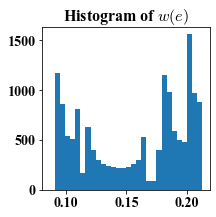

In [65]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

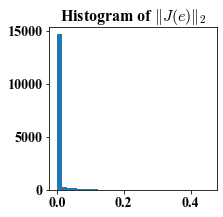

In [66]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

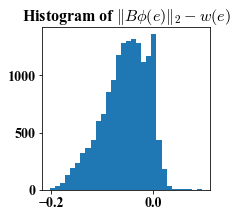

In [67]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

# Plot optimal flow

In [68]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap

to_embed = None # no need to embed if the data is already in <= 3 dimensions, else use isomap/ltsa
embed_dim = None
if to_embed is not None:
    if to_embed == 'isomap':
        fit_obj = Isomap(n_components=embed_dim, n_neighbors=10)
    else:
        fit_obj = LocallyLinearEmbedding(n_components=embed_dim, n_neighbors=10, method='ltsa')
    embedding = fit_obj.fit_transform(X)
else:
    embedding = X

In [69]:
J = J_opt

<IPython.core.display.Javascript object>


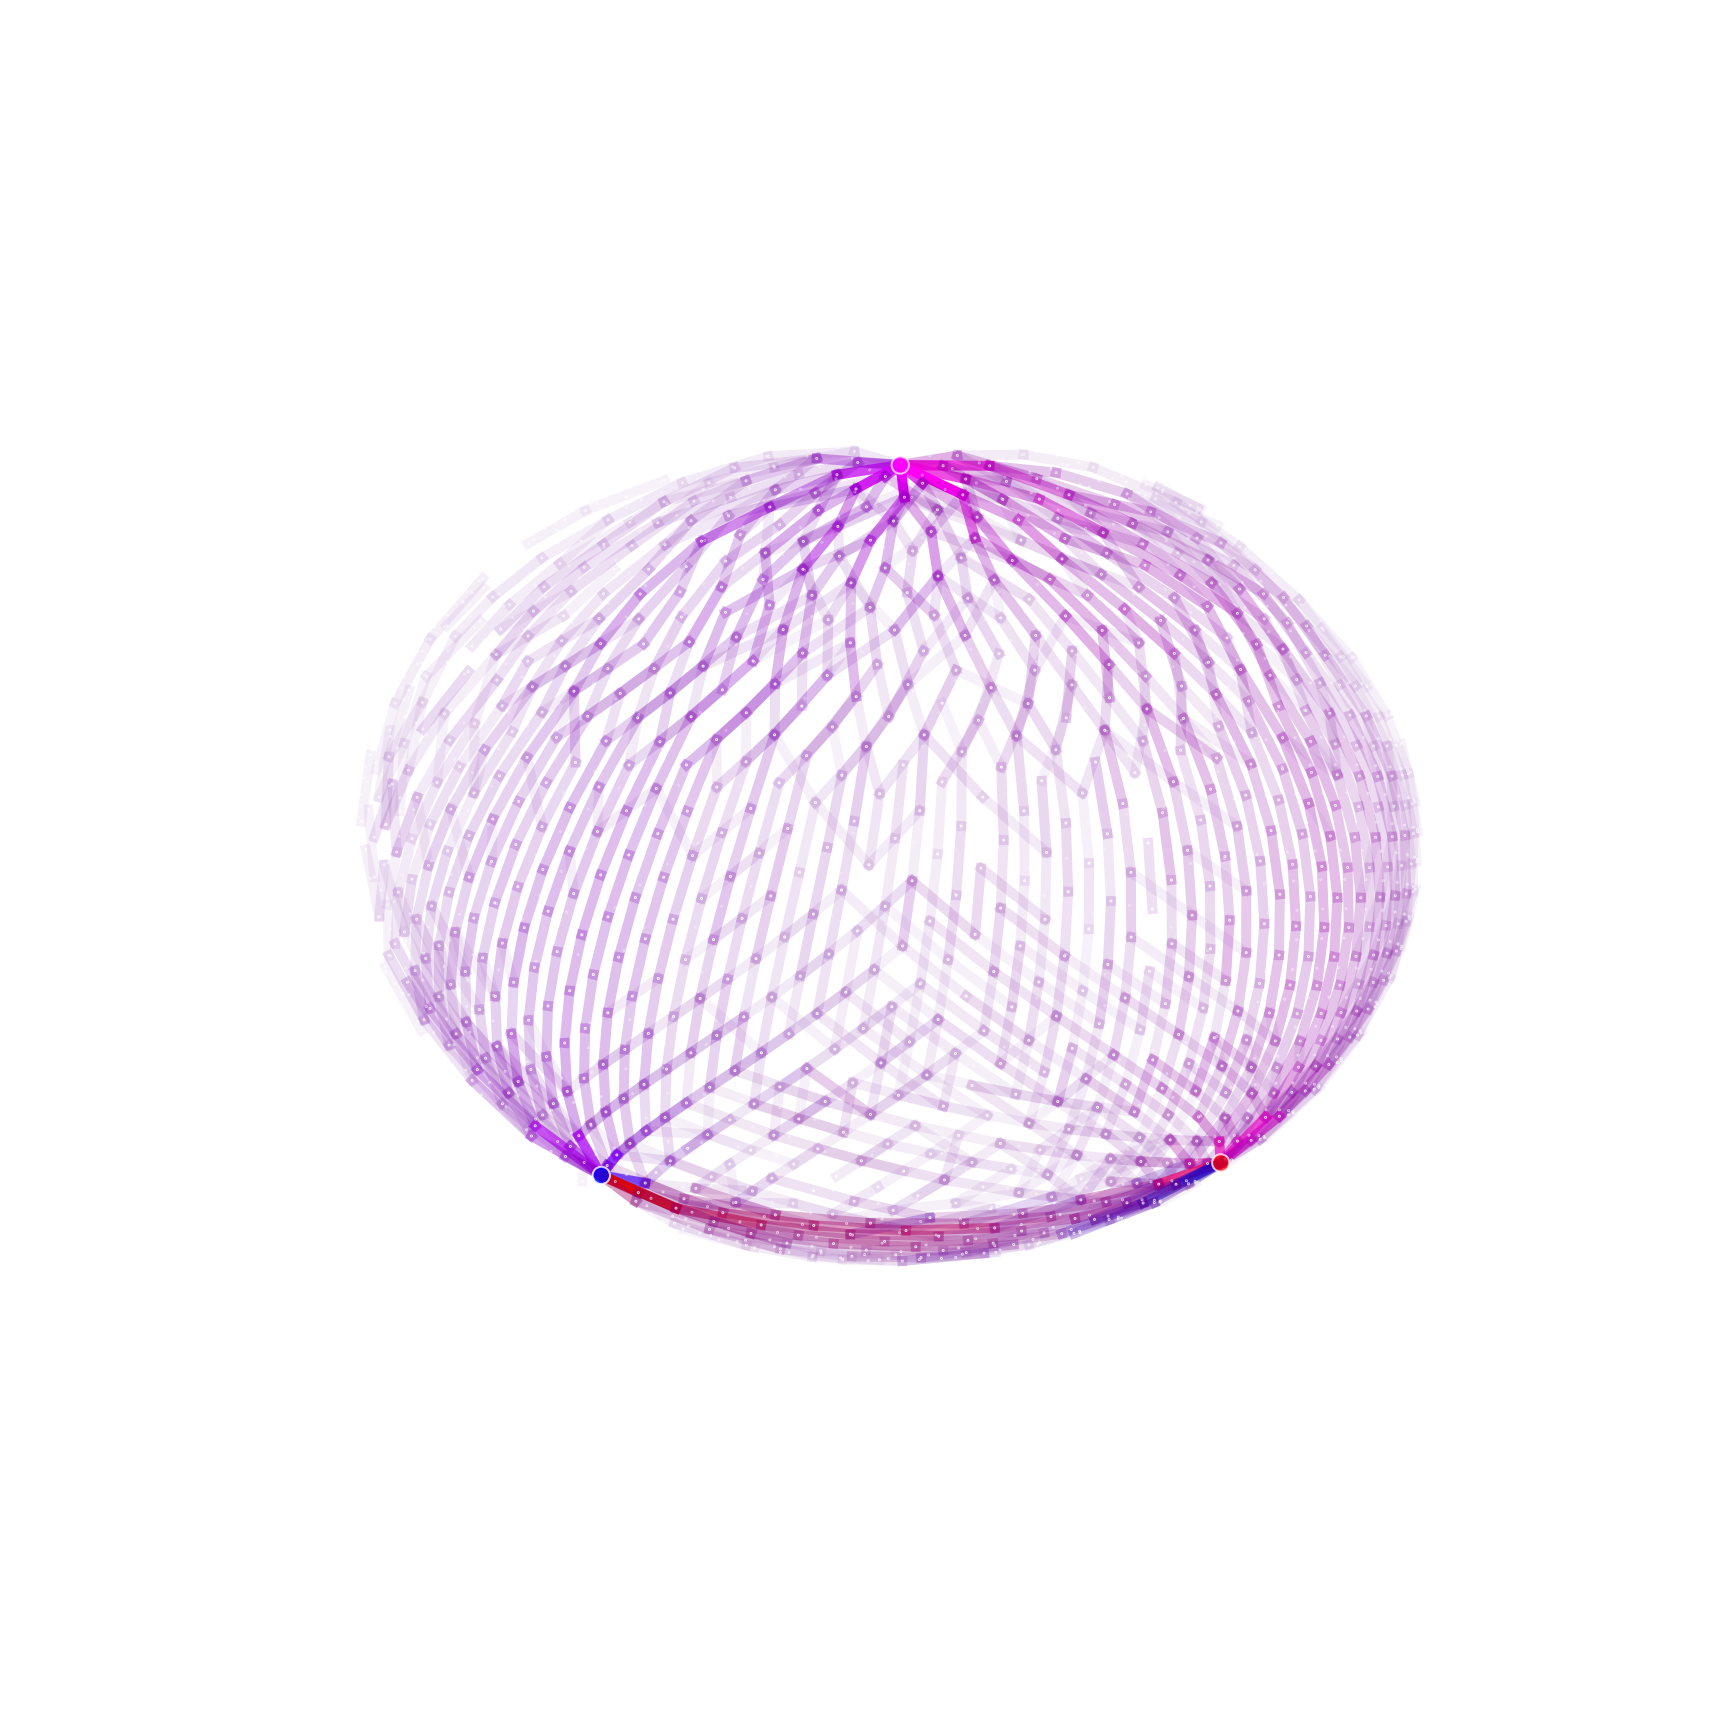

/tmp/ipykernel_63199/2176903746.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [77]:
%matplotlib notebook

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,0,1,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,0,1,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,2] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()

<IPython.core.display.Javascript object>


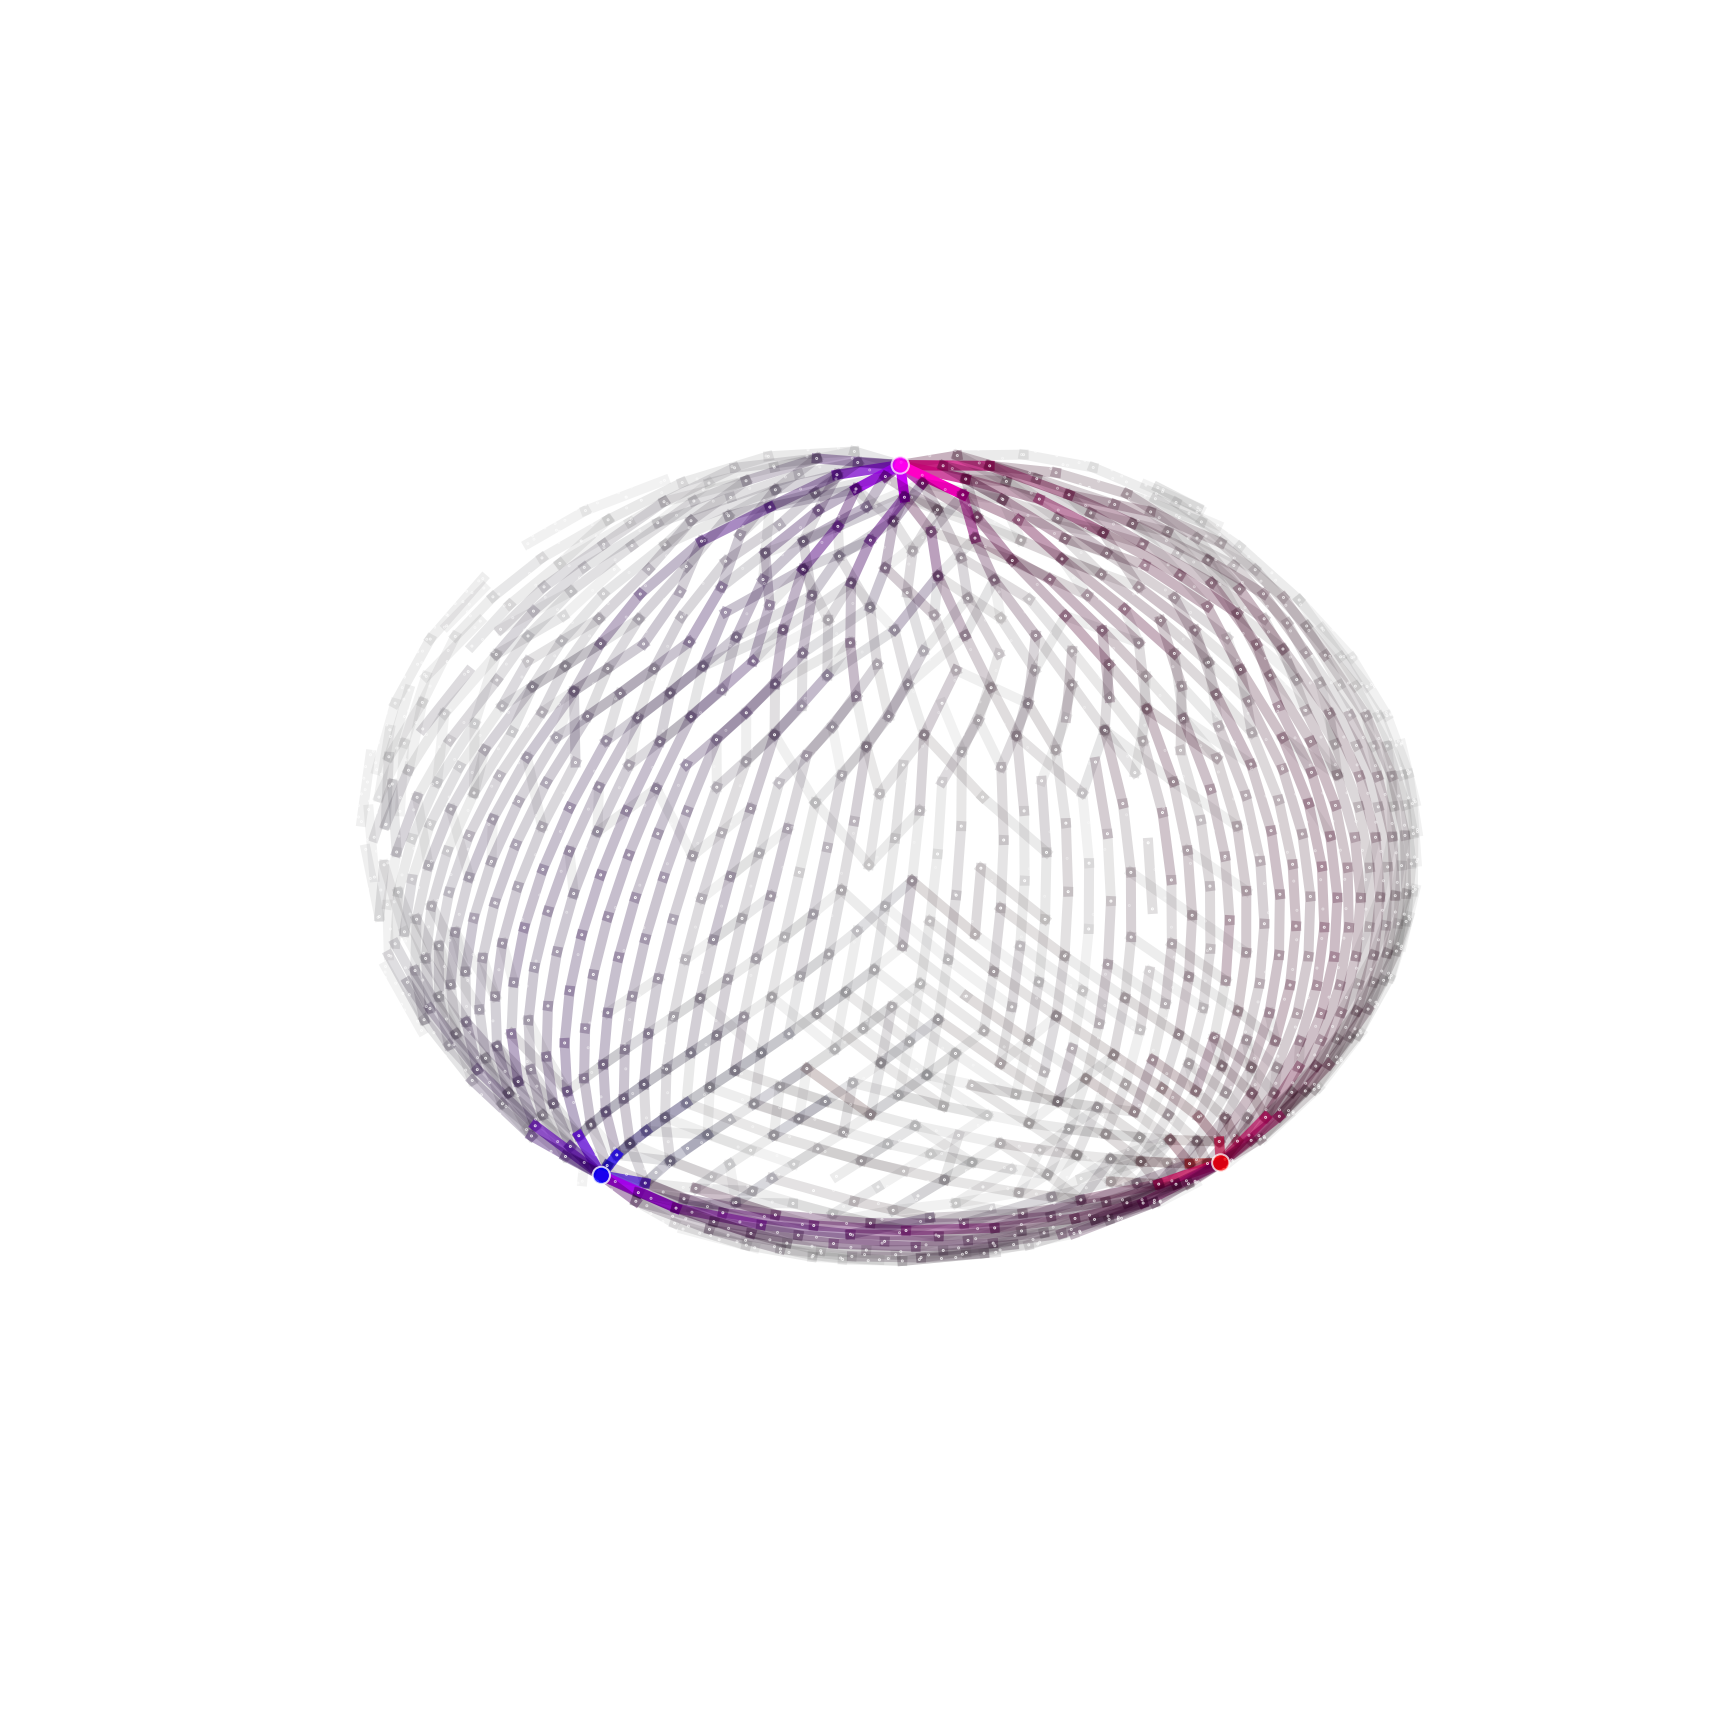

/tmp/ipykernel_63199/2176903746.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [78]:
%matplotlib notebook
node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,0,1,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,0,1,1]

mask = (edge_score > 0)
J_ = J[mask,:]
mJ_ = np.max(np.abs(J_))

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = np.abs(J_[:,0])/mJ_
edge_color[mask,2] = np.abs(J_[:,1])/mJ_
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()

# Plot optimal phi

In [79]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

<IPython.core.display.Javascript object>


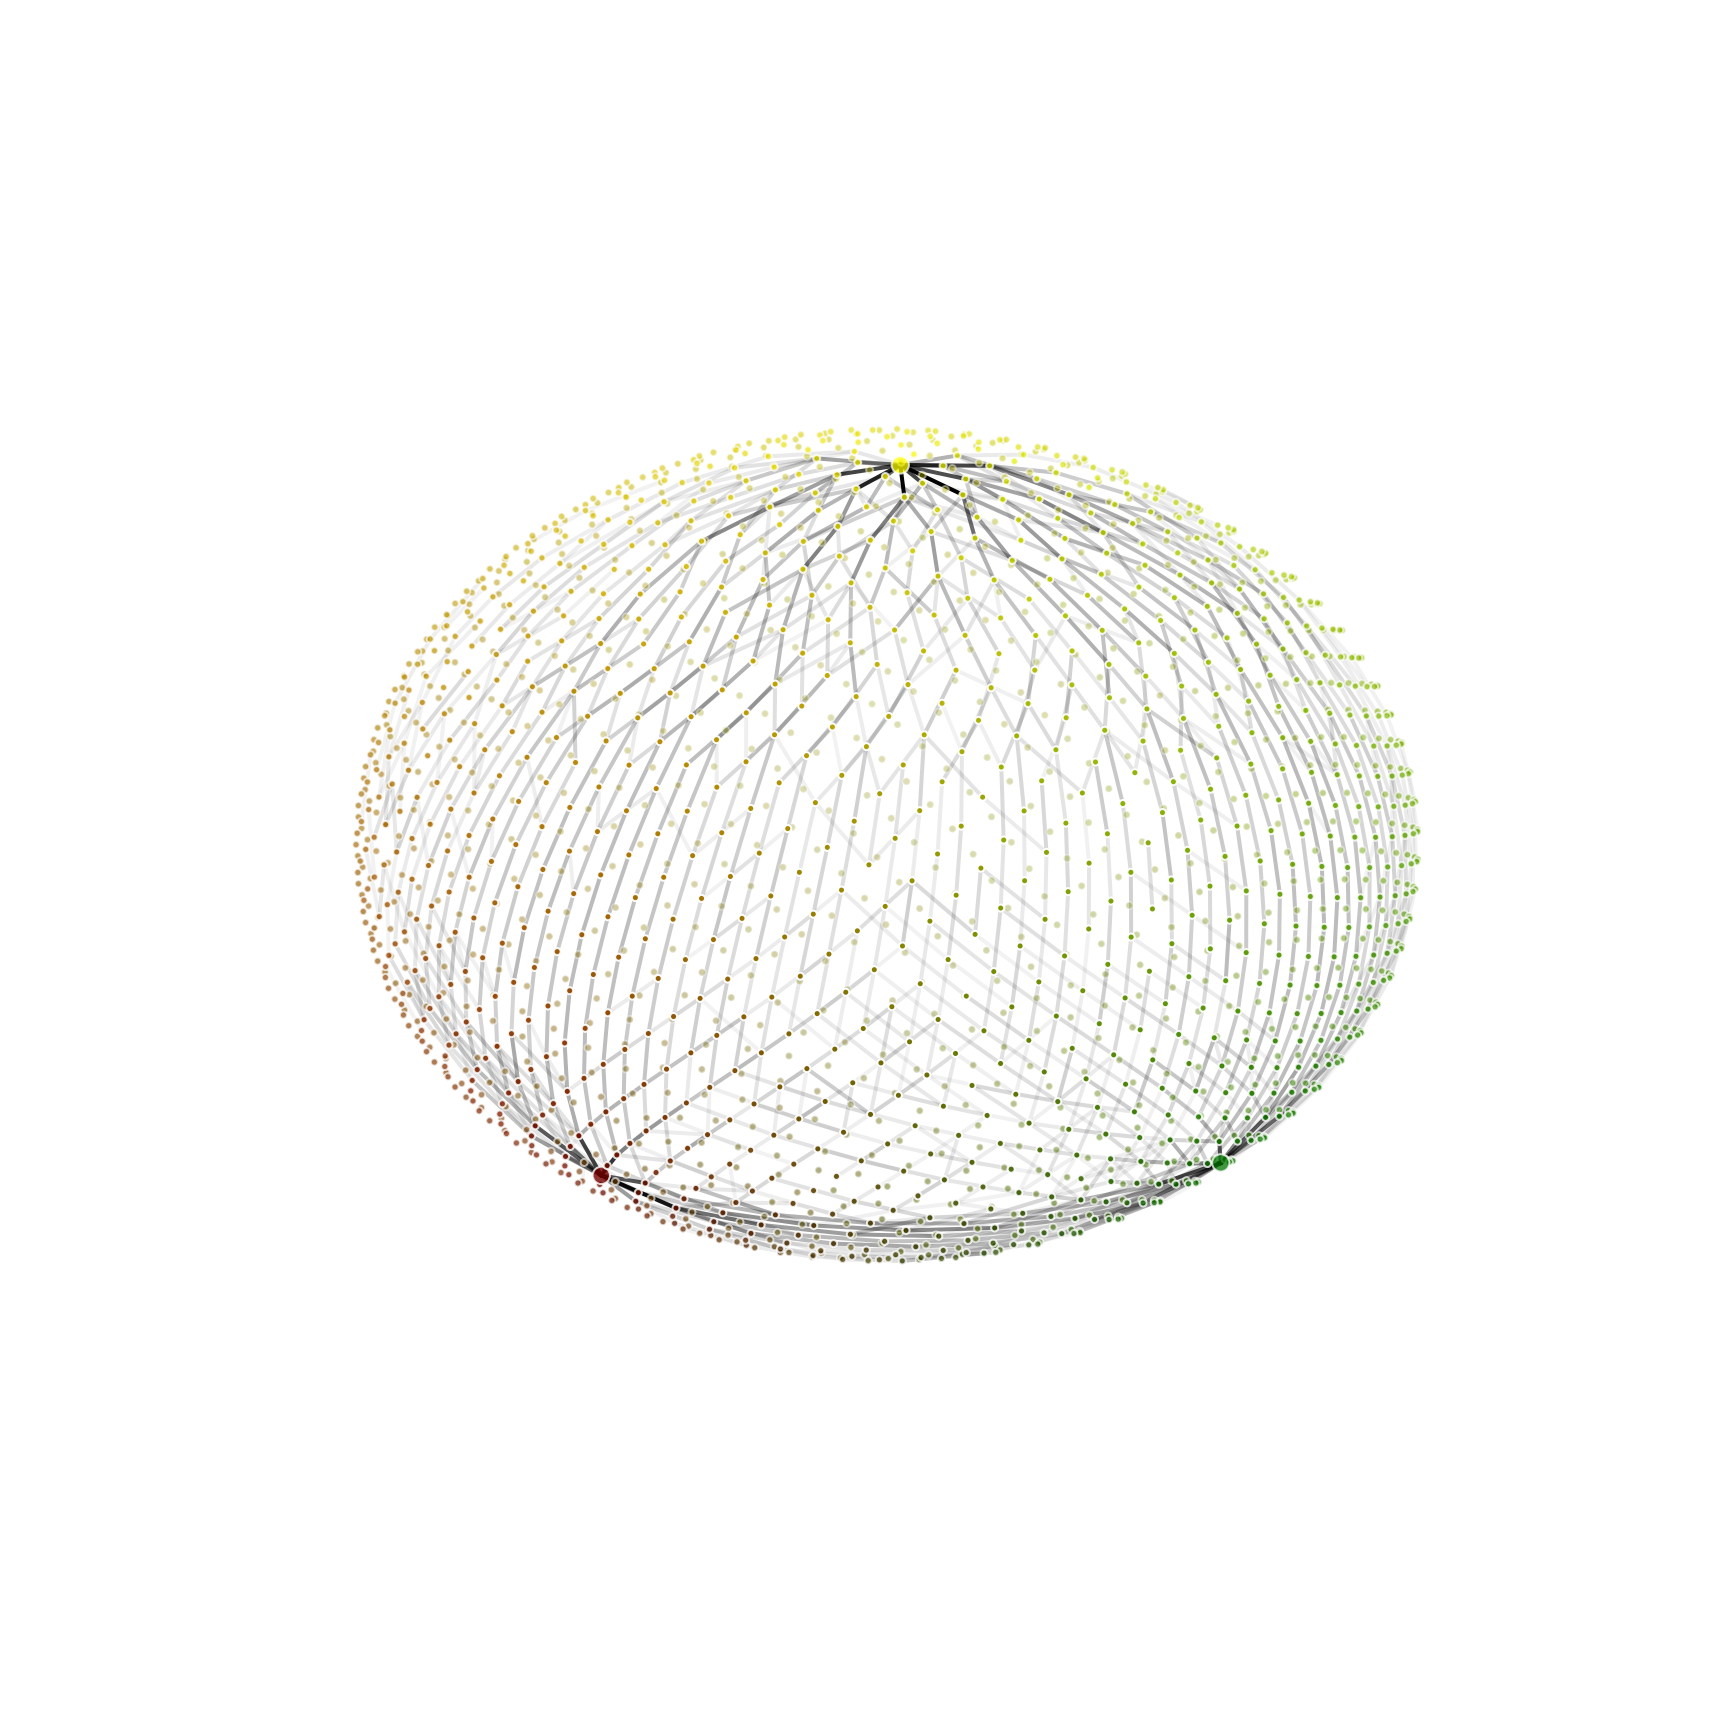

/tmp/ipykernel_63199/2176903746.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [92]:
%matplotlib notebook
node_size = np.ones(n)*50
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = (node_color_[:,0] - np.min(node_color_[:,0]))/np.ptp(node_color_[:,0])
node_color[:,1] = (node_color_[:,1] - np.min(node_color_[:,1]))/np.ptp(node_color_[:,1])

mask = (edge_score > 0)

edge_color = np.zeros((edge_score.shape[0],4))
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=2, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()